This notebook will take the Wikidata dumps that have been parsed into the `../wikidata_claims_refs_parsed.db` file, and search for all claims that have a reference and that adhere to specific criteria.
These criteria will be by the nature of the entities and claims involved, and of the reference URL (if it is a URL).

# Setup

In [1]:
import numpy as np
#import os
#import bz2
#import re
#import random
#import json
#from collections import Counter
import sqlite3
#import time
#import traceback
#import pdb
#from importlib import reload
import wikidata_utils as wdutils
import requests
#import hashlib
#from itertools import islice
#from pprint import pprint
import pandas as pd
import ast
from sample_size import sample_size

import qwikidata
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.sparql import (get_subclasses_of_item,
                              return_sparql_query_results)
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from tqdm.auto import tqdm
tqdm.pandas()

SEED=42

from IPython.display import clear_output

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/gabriela/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
wdAPI = wdutils.CachedWikidataAPI(
    cache_path = '../wikidata_entity_cache.p',
    save_every_x_queries=np.inf
)

In [3]:
db = sqlite3.connect('../wikidata_claims_refs_parsed.db')
cursor = db.cursor()
claims_columns = ['entity_id','claim_id','rank','property_id','datatype','datavalue']
refs_columns = ['reference_id', 'reference_property_id', 'reference_index', 'reference_datatype', 'reference_value']

In [4]:
# Checking first few elements
cursor.execute('select * from refs limit 5;')
head_df = pd.DataFrame(cursor.fetchall())
head_df.columns = refs_columns
head_df

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value
0,7c6b234780b3ee79e341952bbe69fd0e93298176,P854,0,url,{'value': 'http://gwpapers.virginia.edu/histor...
1,7c6b234780b3ee79e341952bbe69fd0e93298176,P123,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
2,dd6c0c287c2d4dfd674f577b65ac1d6b875005ae,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
3,dd6c0c287c2d4dfd674f577b65ac1d6b875005ae,P304,0,string,"{'value': '389', 'type': 'string'}"
4,21e05588017fe6569fd5fb71be9fc6b97812a49b,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."


# Getting all URL references
We will look datatype per datatype as to how best to measure if any of its values are text-rich webpages.

The most promissing are:
- External references as-is
- External IDs with formatter

The database's schema is:
```
CREATE TABLE claims(
                entity_id TEXT,
                claim_id TEXT,
                claim_rank TEXT,
                property_id TEXT,
                datatype TEXT,
                datavalue TEXT,
                PRIMARY KEY (
                    claim_id
                )
        );
CREATE TABLE claims_refs(
                claim_id TEXT,
                reference_id TEXT,
                PRIMARY KEY (
                    claim_id,
                    reference_id
                )
        );
CREATE TABLE refs(
                reference_id TEXT,
                reference_property_id TEXT,
                reference_index TEXT,
                reference_datatype TEXT,
                reference_value TEXT,
                PRIMARY KEY (
                    reference_id,
                    reference_property_id,
                    reference_index
                )
        );
CREATE INDEX entity_id_index on claims (entity_id);
CREATE INDEX reference_id_index on claims_refs (reference_id);
```

In [5]:
cursor.execute('select reference_datatype, count(*) from refs group by reference_datatype;')
datatype_counts = pd.DataFrame(cursor.fetchall())
datatype_counts.columns = ['datatype', 'count']
datatype_counts = datatype_counts.sort_values('count', ascending=False)
datatype_counts

,datatype,count
8,wikibase-item,18389580
6,time,15718562
7,url,12359443
1,external-id,10643420
5,string,792426
3,monolingualtext,349762
0,commonsMedia,613
4,quantity,295
2,globe-coordinate,40
9,wikibase-lexeme,1


<span style="color:red">It would be a nice idea to measure how references have changed from the start to the end of the PhD (April 2020 to now!)</span>. Did any of the reference nodes had their values changed? Why? What types of references suffered this?

## wikibase-item

In [37]:
cursor.execute('select * from refs where reference_datatype="wikibase-item";')
wikibase_item_df = pd.DataFrame(cursor.fetchall())
wikibase_item_df.columns = refs_columns
wikibase_item_df

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value
0,7c6b234780b3ee79e341952bbe69fd0e93298176,P123,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
1,dd6c0c287c2d4dfd674f577b65ac1d6b875005ae,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
2,21e05588017fe6569fd5fb71be9fc6b97812a49b,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
3,37c7a294c3f1a6f3a818e3260b9f63faa132632c,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
4,56f8d326b76b9c4e66e1ebc8252be0eefb28ce05,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
...,...,...,...,...,...
18389575,65835aaf7fcd9f2c3f0f199ef0e9def7117457cb,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
18389576,d05271d3d619d1911e6ba874c4fef956ccf26288,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
18389577,fd731322602a358030e5a6ad9e3e1857803e69e0,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
18389578,321189378868e58e5dfb178893dbc67eae099045,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."


In [84]:
import random
def claim_id_to_claim_url(claim_id):
    claim_id_parts = claim_id.split('$')
    return f'https://www.wikidata.org/wiki/{claim_id_parts[0]}#{claim_id}'

def reference_id_to_claim_id(reference_id):
    try:
        np.random.seed(SEED)
        cursor.execute(f'select claim_id from claims_refs where reference_id="{reference_id}";')
        sql_result = cursor.fetchall()
        randomly_chosen_claim_id = np.random.choice(np.array(sql_result).reshape(-1))
        return randomly_chosen_claim_id
    except Exception:
        print(reference_id)
        print(sql_result)
        raise

def reference_id_to_claim_url(reference_id):
    return claim_id_to_claim_url(reference_id_to_claim_id(reference_id))

In [ ]:
wikibase_item_df_sample = wikibase_item_df.sample(10)
for v in wikibase_item_df_sample.reference_id.apply(reference_id_to_claim_url):
    print(v)

Checking this by hand we see many references have other predicates other than just a wikibase_item.

What wikibase items are used the most? What other predicates are used in conjunction to this?

In [65]:
def reference_value_to_wikibase_item_id(reference_value):
    if reference_value in ['novalue','somevalue']:
        return reference_value
    reference_value = ast.literal_eval(reference_value)
    assert reference_value['type'] == 'wikibase-entityid'
    return reference_value['value']['id']

wikibase_item_df['wikibase_item'] = wikibase_item_df.reference_value.parallel_apply(reference_value_to_wikibase_item_id)

What wikibase items are used the most?

In [98]:
wikibase_item_df_counts = 100*wikibase_item_df.wikibase_item.value_counts()/wikibase_item_df.shape[0]
wikibase_item_df_counts = wikibase_item_df_counts\
    .reset_index()\
    .rename(columns={'index':'wikibase_item','wikibase_item':'counts'})
wikibase_item_df_counts = wikibase_item_df_counts[wikibase_item_df_counts['counts'] >= 0.5]
# We take only those with more than 0.5% of frequency

print(f'Taking {wikibase_item_df_counts.shape[0]} most frequent predicates ({wikibase_item_df_counts.counts.sum()}% of total)')

wikibase_item_df_counts['label'] = wikibase_item_df_counts.wikibase_item.apply(wdAPI.get_label)
wikibase_item_df_counts

Taking 18 most frequent predicates (80.08056736477938% of total)


,wikibase_item,counts,label
0,Q5412157,35.721191,"(Europe PubMed Central, en)"
1,Q229883,11.078464,"(PubMed Central, en)"
2,Q5188229,6.887009,"(Crossref, en)"
3,Q180686,3.619251,"(PubMed, en)"
4,Q105771474,3.534779,"(inferred from PubMed ID database lookup, en)"
5,Q20641742,2.463395,"(NCBI Gene, en)"
6,Q905695,2.087682,"(UniProt, en)"
7,Q54919,2.084659,"(Virtual International Authority File, en)"
8,Q328,1.791292,"(English Wikipedia, en)"
9,Q1860,1.766756,"(English, en)"


Almost all are a database that should have unique identifiers and a formatter for URL

Let's make sure these sources have unique identifiers and formatter URLs

There is no way to reliably link a source (like Europe PubMed Central) to an external ID property (like PubMed ID) through wikidata statements. Instead, we will check each reference that links to those sources and see if there is any ID or link

In [169]:
def get_ext_id_and_url_count_per_wikibase_item(wikibase_item):
    #wikibase_item = 'Q5412157'
    reference_ids = wikibase_item_df[wikibase_item_df['wikibase_item'] == wikibase_item].reference_id.drop_duplicates()
    reference_ids = reference_ids.sample(sample_size(reference_ids.shape[0], confidence_level=99, confidence_interval=1), random_state=SEED)
    ext_id_count = 0
    url_count = 0
    size = reference_ids.shape[0]
    for i, reference_id in enumerate(reference_ids):
        #print(str(round(100*i/size, 5)).ljust(10,' '),'%', end='\r')
        cursor.execute(
            f'select count(*) from refs where reference_id="{reference_id}" and reference_datatype="external-id";'
        )
        ext_id_count = ext_id_count + min(1, cursor.fetchall()[0][0])
        cursor.execute(
            f'select count(*) from refs where reference_id="{reference_id}" and reference_datatype="url";'
        )
        url_count = url_count + min(1, cursor.fetchall()[0][0])
    return({
        'size':size,
        'ext_id_count':ext_id_count,
        'url_count':url_count
    })

r = wikibase_item_df_counts.wikibase_item.apply(get_ext_id_and_url_count_per_wikibase_item)
wikibase_item_df_counts[['size','ext_id_count','url_count']] = pd.DataFrame(r.tolist())
wikibase_item_df_counts['ext_id_count'] = wikibase_item_df_counts['ext_id_count']/wikibase_item_df_counts['size']
wikibase_item_df_counts['url_count'] = wikibase_item_df_counts['url_count']/wikibase_item_df_counts['size']
wikibase_item_df_counts


,wikibase_item,counts,label,size,ext_id_count,url_count
0,Q5412157,35.721191,"(Europe PubMed Central, en)",16471,0.999879,0.728068
1,Q229883,11.078464,"(PubMed Central, en)",16380,0.000061,0.999756
2,Q5188229,6.887009,"(Crossref, en)",16300,0.023129,0.999939
3,Q180686,3.619251,"(PubMed, en)",16113,0.020542,0.979333
4,Q105771474,3.534779,"(inferred from PubMed ID database lookup, en)",16104,0.000000,1.000000
5,Q20641742,2.463395,"(NCBI Gene, en)",15932,0.999937,0.000000
6,Q905695,2.087682,"(UniProt, en)",15832,0.999432,0.271475
7,Q54919,2.084659,"(Virtual International Authority File, en)",15831,0.931148,0.074411
8,Q328,1.791292,"(English Wikipedia, en)",15725,0.000064,0.968331
9,Q1860,1.766756,"(English, en)",15714,0.970854,0.029273


All of these have 100% (or nearly) coverage of either an external ID or an URL.
This means we do not have to do anything with wikibase_item datatype predicates, as the relevant info will be either on a external-id or a url datatype predicate on the same reference.

Also, we can ignore most datatypes of reference predicates, as they do not give us any information towards an URL, like:
- time
- string (too broad, could be anything, depends on a case-by-case of predicates)
- monolingualtext (same as string)
- commonsMedia (pics do not help here)
- quantity
- globe-coordinate
- wikibase-lexeme
- wikibase-property

So we are left with **URL** and **External ID**

## url
Very straightforward

In [6]:
cursor.execute('select * from refs where reference_datatype="url";')
url_df = pd.DataFrame(cursor.fetchall())
url_df.columns = refs_columns
url_df
#12359443

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value
0,7c6b234780b3ee79e341952bbe69fd0e93298176,P854,0,url,{'value': 'http://gwpapers.virginia.edu/histor...
1,f4ab6912f1209370d05f150676c58c279cad65a4,P854,0,url,{'value': 'http://www.anb.org/articles/02/02-0...
2,866ee1637fa3fdd6247ac7bab3f272a8cccc700c,P854,0,url,{'value': 'http://www.timelines.ws/subjects/Wi...
3,3cbd913bf0037d125338e8526a1b2285709c5edf,P854,0,url,{'value': 'http://www.britannica.com/blogs/200...
4,a1850870d817be0c404a0e2ccd45573e9298a9a3,P854,0,url,{'value': 'https://elections.lib.tufts.edu/cat...
...,...,...,...,...,...
12359438,aff9b97be9ba1140d7be77fac1e5d47a6c7f0c0d,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...
12359439,0967cbb5cbdb2b187ec64744164e8fe65da291f4,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...
12359440,133a6b191748549aa03cb301f0ff0317003aa1a4,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...
12359441,eebd6a23689ea4c8fb51dee4a7e46e50867850a9,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...


In [7]:
def reference_value_to_url(reference_value):
    if reference_value in ['novalue','somevalue']:
        return reference_value
    reference_value = ast.literal_eval(reference_value)
    assert reference_value['type'] == 'string'
    return reference_value['value']

url_df['url'] = url_df.reference_value.parallel_apply(reference_value_to_url)

In [8]:
url_df
#12359443 

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value,url
0,7c6b234780b3ee79e341952bbe69fd0e93298176,P854,0,url,{'value': 'http://gwpapers.virginia.edu/histor...,http://gwpapers.virginia.edu/history/articles/...
1,f4ab6912f1209370d05f150676c58c279cad65a4,P854,0,url,{'value': 'http://www.anb.org/articles/02/02-0...,http://www.anb.org/articles/02/02-00332.html
2,866ee1637fa3fdd6247ac7bab3f272a8cccc700c,P854,0,url,{'value': 'http://www.timelines.ws/subjects/Wi...,http://www.timelines.ws/subjects/Wine.HTML
3,3cbd913bf0037d125338e8526a1b2285709c5edf,P854,0,url,{'value': 'http://www.britannica.com/blogs/200...,http://www.britannica.com/blogs/2007/06/from-c...
4,a1850870d817be0c404a0e2ccd45573e9298a9a3,P854,0,url,{'value': 'https://elections.lib.tufts.edu/cat...,https://elections.lib.tufts.edu/catalog/WG0011
...,...,...,...,...,...,...
12359438,aff9b97be9ba1140d7be77fac1e5d47a6c7f0c0d,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...,https://gepris-historisch.dfg.de/person/5113388
12359439,0967cbb5cbdb2b187ec64744164e8fe65da291f4,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...,https://gepris-historisch.dfg.de/person/5113648
12359440,133a6b191748549aa03cb301f0ff0317003aa1a4,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...,https://gepris-historisch.dfg.de/person/5113925
12359441,eebd6a23689ea4c8fb51dee4a7e46e50867850a9,P854,0,url,{'value': 'https://gepris-historisch.dfg.de/pe...,https://gepris-historisch.dfg.de/person/5140103


## external-id
Less straight-forward

In [9]:
cursor.execute('select * from refs where reference_datatype="external-id";')
ext_id_df = pd.DataFrame(cursor.fetchall())
ext_id_df.columns = refs_columns
ext_id_df
#10643420

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value
0,56f8d326b76b9c4e66e1ebc8252be0eefb28ce05,P4638,0,external-id,"{'value': 'p2570.htm#i25694', 'type': 'string'}"
1,4aa91134a9b987337fc294594f28e07e0938d99f,P227,0,external-id,"{'value': '11876439X', 'type': 'string'}"
2,beb121097bc90dd6a9c2295e2c67f2607a16b636,P6844,0,external-id,"{'value': '112676', 'type': 'string'}"
3,317f48379edf7f1df119ee4c8877e8ca41248f29,P2383,0,external-id,"{'value': '107557', 'type': 'string'}"
4,be7687e717ca7550b698d1096cb1d6772bd17884,P3430,0,external-id,"{'value': 'w6028ps4', 'type': 'string'}"
...,...,...,...,...,...
10643415,d05271d3d619d1911e6ba874c4fef956ccf26288,P6736,0,external-id,"{'value': '45148', 'type': 'string'}"
10643416,fd731322602a358030e5a6ad9e3e1857803e69e0,P6736,0,external-id,"{'value': '44930', 'type': 'string'}"
10643417,321189378868e58e5dfb178893dbc67eae099045,P6736,0,external-id,"{'value': '44750', 'type': 'string'}"
10643418,ae1d88b5b2748fee1493e14dc5eccd0462c6c107,P6736,0,external-id,"{'value': '43685', 'type': 'string'}"


In [10]:
def reference_value_to_external_id(reference_value):
    if reference_value in ['novalue','somevalue']:
        return reference_value
    reference_value = ast.literal_eval(reference_value)
    assert reference_value['type'] == 'string'
    return reference_value['value']

ext_id_df['ext_id'] = ext_id_df.reference_value.parallel_apply(reference_value_to_external_id)

In [17]:
def get_formatter_url(entity_id):
    try:
        sparql_query = '''
            SELECT ?item ?itemLabel 
            WHERE 
            {
              wd:$1 wdt:P1630 ?item.
              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
            }
        '''.replace('$1',entity_id)
        sparql_results = wdAPI.query_sparql_endpoint(sparql_query)
        if len(sparql_results['results']['bindings']) > 0:
            return sparql_results['results']['bindings'][0]['item']['value']
        else:
            return 'no_formatter_url'
    except Exception:
        print(entity_id)
        print(sparql_results)
        raise
        
ext_id_df['formatter_url'] = ext_id_df['reference_property_id'].progress_apply(get_formatter_url)

In [18]:
wdAPI.save_entity_cache(True)

In [20]:
ext_id_df['url'] = ext_id_df.parallel_apply(
    lambda x : x['formatter_url'].replace('$1', x['ext_id']), axis=1
)

In [21]:
ext_id_df

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value,ext_id,formatter_url,url
0,56f8d326b76b9c4e66e1ebc8252be0eefb28ce05,P4638,0,external-id,"{'value': 'p2570.htm#i25694', 'type': 'string'}",p2570.htm#i25694,https://wikidata-externalid-url.toolforge.org/...,https://wikidata-externalid-url.toolforge.org/...
1,4aa91134a9b987337fc294594f28e07e0938d99f,P227,0,external-id,"{'value': '11876439X', 'type': 'string'}",11876439X,https://d-nb.info/gnd/$1,https://d-nb.info/gnd/11876439X
2,beb121097bc90dd6a9c2295e2c67f2607a16b636,P6844,0,external-id,"{'value': '112676', 'type': 'string'}",112676,https://en.isabart.org/person/$1,https://en.isabart.org/person/112676
3,317f48379edf7f1df119ee4c8877e8ca41248f29,P2383,0,external-id,"{'value': '107557', 'type': 'string'}",107557,https://cths.fr/an/savant.php?id=$1,https://cths.fr/an/savant.php?id=107557
4,be7687e717ca7550b698d1096cb1d6772bd17884,P3430,0,external-id,"{'value': 'w6028ps4', 'type': 'string'}",w6028ps4,https://snaccooperative.org/ark:/99166/$1,https://snaccooperative.org/ark:/99166/w6028ps4
...,...,...,...,...,...,...,...,...
10643415,d05271d3d619d1911e6ba874c4fef956ccf26288,P6736,0,external-id,"{'value': '45148', 'type': 'string'}",45148,https://www.drobnepamatky.cz/node/$1,https://www.drobnepamatky.cz/node/45148
10643416,fd731322602a358030e5a6ad9e3e1857803e69e0,P6736,0,external-id,"{'value': '44930', 'type': 'string'}",44930,https://www.drobnepamatky.cz/node/$1,https://www.drobnepamatky.cz/node/44930
10643417,321189378868e58e5dfb178893dbc67eae099045,P6736,0,external-id,"{'value': '44750', 'type': 'string'}",44750,https://www.drobnepamatky.cz/node/$1,https://www.drobnepamatky.cz/node/44750
10643418,ae1d88b5b2748fee1493e14dc5eccd0462c6c107,P6736,0,external-id,"{'value': '43685', 'type': 'string'}",43685,https://www.drobnepamatky.cz/node/$1,https://www.drobnepamatky.cz/node/43685


## Joining URL dataframes

In [ ]:
columns_for_join = ['reference_id', 'reference_property_id','reference_index','reference_datatype','url']
url_df_pre_join = url_df[columns_for_join]
ext_id_df_pre_join = ext_id_df[columns_for_join]
all_url_df = pd.concat([url_df_pre_join,ext_id_df_pre_join])
all_url_df = all_url_df.sort_values(['reference_id','reference_index'])
# drop those with url = 'no_formatter_url'
all_url_df = all_url_df[all_url_df['url'] != 'no_formatter_url'].reset_index(drop=True)
# drop those with url = somevalue and novalue
all_url_df = all_url_df[~all_url_df['url'].isin(['somevalue','novalue'])]

In [23]:
all_url_df

,reference_id,reference_property_id,reference_index,reference_datatype,url
0,0000018cfee536c41bf7bc66dde3252441c63bff,P214,0,external-id,https://viaf.org/viaf/83762586/
1,000002dbdf8e9565a1fe3f537d2e51376bc64b2b,P854,0,url,https://www.ebi.ac.uk/europepmc/webservices/re...
2,000002dbdf8e9565a1fe3f537d2e51376bc64b2b,P698,0,external-id,https://pubmed.ncbi.nlm.nih.gov/14678706
3,000006c2c777b4f1caba6b3cc73a417f158f5514,P854,0,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...
4,000008ae3380804df3d4fd865fd6fd3533cfa505,P854,0,url,https://api.crossref.org/works/10.1186%2F1750-...
...,...,...,...,...,...
22700373,fffffd057bb72db2287bf50c77ca4985f60589e1,P854,0,url,http://europepmc.org/abstract/MED/18420992
22700374,fffffd057bb72db2287bf50c77ca4985f60589e1,P698,0,external-id,https://pubmed.ncbi.nlm.nih.gov/18420992
22700375,fffffe0ea372b8b84c19052c1be41c34ff6f49fa,P4656,0,url,https://en.wikipedia.org/w/index.php?title=Cro...
22700376,ffffffcce9e849770c8bafed243537f56c8670e3,P854,0,url,http://europepmc.org/abstract/MED/28073543


In [76]:
reference_id_counts = all_url_df.reference_id.value_counts().reset_index()
reference_id_counts.columns = ['reference_id', 'counts']
print(100*reference_id_counts[reference_id_counts['counts'] > 1].shape[0]/reference_id_counts.shape[0])
print(100*reference_id_counts[reference_id_counts['counts'] > 2].shape[0]/reference_id_counts.shape[0])

29.424388096184543
0.025185052534445522


29% have more than 1 URL, 0.02% have more than 2
It would be good to only keep those cases where there is only one URL per reference_id.
This is because it would (ideally) mean that URL is the only web resource needed to confirm the info, as opposed to having multiple URLs and perhaps needing to combine information on both (which is against Wikidata guidelines but people are people)

In [25]:
reference_id_counts_equal_1 = reference_id_counts[reference_id_counts['counts'] == 1].reference_id.tolist()
all_url_df_eq1 = all_url_df[all_url_df.reference_id.isin(reference_id_counts_equal_1)]
all_url_df_eq1 = all_url_df_eq1.reset_index(drop=True).drop('reference_index', axis=1)
all_url_df_eq1

,reference_id,reference_property_id,reference_datatype,url
0,0000018cfee536c41bf7bc66dde3252441c63bff,P214,external-id,https://viaf.org/viaf/83762586/
1,000006c2c777b4f1caba6b3cc73a417f158f5514,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...
2,000008ae3380804df3d4fd865fd6fd3533cfa505,P854,url,https://api.crossref.org/works/10.1186%2F1750-...
3,000008d3e710bed3a1234005f4ccefa48a87176b,P854,url,https://pubmed.ncbi.nlm.nih.gov/25054964
4,00000b00ef087e286c15ff8b95786aa3c10b77e7,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...
...,...,...,...,...
12374874,fffffa2931d9a21339c52108d08be7219a6b7e2a,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...
12374875,fffffa8350d0f51b9c829b02a868a990b90a032a,P854,url,https://pub.orcid.org/v3.0_rc1/0000-0002-9070-...
12374876,fffffb02eb0bfec85379286cfa97baa993e2a419,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...
12374877,fffffc25f5fa020aa084829db4a5ab5083f64751,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...


In [183]:
# DO THIS WHEN THE LIST OF REFERENCE HAS BEEN CLEANED (REMOVED BAD REFERENCES)
#from tqdm.auto import tqdm
#tqdm.pandas()
#all_url_df_eq1['claim_id'] = all_url_df_eq1.reference_id.progress_apply(reference_id_to_claim_id)

/home/gabriela/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Cleaning the dataset
Here, we will remove references that we know are not good for the task, meaning references pointing to URLs that are not text-rich websites. We will do this by:
- Looking at the URLS for domains that normally lack this desirable property and removing all occurences;
    - We will be doing this first, as it will reduce the list a lot before checking with requests (which takes a very long time)
- Looking at URLs that point to files (json, csv, etc) that are not html or txt;
    - Even txt might be downloadable instead of browser-processable
    - Remaining urls here can be checked with 'requests' to see what format is returned
- Look at the websites using a crawler (headless browser, so that javascript has a chance to load) and extracting all text, and seeing if it's prose-like or mainly boiler-plate and detached sentences.

### Domain analysis

In [ ]:
from urllib.parse import urlparse

all_url_df_eq1[['scheme','netloc','path','params','query','fragment']] =\
    pd.DataFrame(all_url_df_eq1.url.parallel_apply(urlparse).tolist())

In [9]:
all_url_df_eq1 = pd.read_csv('all_url_df_eq1.csv')

/home/gabriela/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Scheme

In [83]:
print('Scheme count breakdown:')
print(all_url_df_eq1.scheme.value_counts(), '\n')

# First, all FTP are out, as these are file transfer and would just load files.
#most of them are csvs, zips, pdfs.
# Second, mailto(why is that even here) are also useless for us

#for v in sorted(all_url_df_eq1[all_url_df_eq1.scheme == 'mailto'].url.unique()):
#    print(v)

all_url_df_eq1 = all_url_df_eq1[all_url_df_eq1.scheme.isin(['https','http'])]

Scheme count breakdown:
https     10555999
http       1818820
ftp             55
mailto           2
Name: scheme, dtype: int64 



#### Netloc

In [12]:
print('Netloc count breakdown:')
netloc_counts = all_url_df_eq1.netloc.value_counts()
netloc_counts = netloc_counts.reset_index()
netloc_counts.columns = ['netloc', 'counts']
netloc_counts['perc'] = 100*netloc_counts['counts']/netloc_counts['counts'].sum()
netloc_counts

Netloc count breakdown:


,netloc,counts,perc
0,pubmed.ncbi.nlm.nih.gov,2057021,16.622564
1,eutils.ncbi.nlm.nih.gov,2038028,16.469083
2,api.crossref.org,1245886,10.067870
3,viaf.org,734101,5.932191
4,www.ncbi.nlm.nih.gov,460680,3.722705
...,...,...,...
66595,questionedistile.gazzetta.it,1,0.000008
66596,www.elisabeth-mase.de,1,0.000008
66597,www.evoluciospszichologia.hu,1,0.000008
66598,www.heroines.ca,1,0.000008


In [13]:
netloc_counts_f100 = netloc_counts.head(100)
netloc_counts_f100['examples'] = netloc_counts_f100.netloc.parallel_apply(
    lambda x : all_url_df_eq1[all_url_df_eq1['netloc'] == x].sample(10, random_state=SEED).url.tolist()
)
clear_output(wait=True)
netloc_counts_f100.perc.sum()
# The 100 most frequent are 90% of the url dataset so far 

89.39458929352966

In [14]:
# Loop to analyse the i-th netloc
#i = 86
#print(netloc_counts_f100.loc[i,'netloc'])
#print(netloc_counts_f100.loc[i,'counts'])
#for v in netloc_counts_f100.examples[i]:
#    print(v)

We sampled 10 urls for each and manually inspected them. Those with less than 5 text-rich URLs were excluded.

List of bad netlocs (might have been better to just select the good ones):
- pubmed.ncbi.nlm.nih.gov (bad layout) #means text page, but organised like a table or a fieldname: fieldcontent way
- eutils.ncbi.nlm.nih.gov (bad format) #means json, csv, etc
- api.crossref.org (bad format)
- viaf.org (bad layout)
- www.ncbi.nlm.nih.gov (bad layout unless there is a summary, which very very few have)
- europepmc.org (bad layout)
- www.ebi.ac.uk (bad layout)
- www.uniprot.org (bad layout)
- pub.orcid.org (bad format, it's a xml?)
- wikidata-externalid-url.toolforge.org
    - These mainly link to another website by the url_prefix argument, so let's just get that instead.
- www.cnki.com.cn (all in chinese)
- orcid.org (bad layout unless there is a biography, which very few do)
- d-nb.info (bad layout and all in German)
- edits.nationalmap.gov (bad layout)
- identifiers.org (bad layout)
- tools.wmflabs.org (bad format)
- de.wikipedia.org (bad language)
- www.historicengland.org.uk (bad layout)
- ratings.fide.com (bad layout)
- en.cnki.com.cn (bad layout and format (pdf))
- mirtarbase.mbc.nctu.edu.tw (404)
- data.riksdagen.se (in swedish?)
- it.wikipedia.org (in italian)
- aleph.nkp.cz (in czech)
- pl.wikipedia.org (in polish)
- w3id.org (bad layout)
- ru.wikipedia.org (in russian)
- es.wikipedia.org (in spanish)
- catalogue.bnf.fr (in french)
- fr.wikipedia.org (in french)
- www.dacs.org.uk (no actual data there)
- pubchem.ncbi.nlm.nih.gov (bad layout)
- github.com (bad format most of the times)
- web.expasy.org (bad layout)
- portal.issn.org (bad layout)
- scigraph.springernature.com (bad layout)
- www.catholic-hierarchy.org (bad layout)
- rkd.nl (in dutch)
- libris.kb.se (in swedish)
- geoportal.bayern.de (in german)
- data.bnf.fr (in french)
- www.holocaust.cz (bad format)
- uk.wikipedia.org (in ukranian)
- www.pamatnik-terezin.cz (in czech)
- purl.org (bad format and layout, includes image)
- www.chemspider.com (bad layout)
- commons.wikimedia.org (bad format, images)
- www.grid.ac (bad layout)
- id.worldcat.org (bad layout)
- www.transfermarkt.com (bad layout and some don't load)
- doi.org (unpredictible)
- www.legislation.gov.uk (bad layout and also format, as the links lead to a content list and sometimes to pdfs)
- www.cdc.gov (bad layout)
- ja.wikipedia.org (in japanese)
- www.idref.fr (in french)
- www.imdb.com
    - if not /name
- clevelandart.org (bad layout and format, as it is images)
- archive.org (bad format, as it is pdfs)
- experimental.worldcat.org (bad format, it is linked data)
- amigo.geneontology.org (bad layout)
- web.archive.org (unpredictible)
    - depends on the url after the web.archive url. Perhaps revisit if we need more URLs
- www.biodiversitylibrary.org (bad layout)
- www.ipni.org bad layout
- www.geonames.org bad format, geographic 
- sv.wikipedia.org (not in english)
- id.library.wales bad layout
- www.google.com (what the hell?? hahahaha "source? google it!")
- pt.wikipedia.org (not in english)
- unpkg.com (bad format, json)
- cdn.jsdelivr.net (bad format, json)
- www.webumenia.sk (bad layout)
- id.loc.gov (bad layout)
- messes.info (bad layout, not in english)
- precision.fda.gov (bad layout)
- echa.europa.eu (bad layout)
- de.wikisource.org (not in english)
- www.openstreetmap.org (bad format, geographic)
- www.nationaltrustcollections.org.uk (bad layout and is images)
- data.collectienederland.nl (bad layout, not in english)
- www.jstor.org (bad format)
- www.rcsb.org (bad layout and format)
- collection.nationalmuseum.se (bad layout, and is images)
- www.iaph.es not in english
- stadnamn.kartverket.no not in english
- www.lexml.gov.br bad layout, not in english
- www.metmuseum.org bad layout
- www.sammlung.pinakothek.de bad layout, but also giving 404
- he.wikipedia.org not in english
- hdl.handle.net unpredictible, not in english, bad layout
- mak.bn.org.pl bad layout, not in english
- ca.wikipedia.org not in english
- ethos.bl.uk bad layout
- opendata.muis.ee bad layout

Questions:
- can any "not in english" case be changed to english?
    - can this be done through auto-translation?
- can any "bad layout" case perhaps still work? try that later!
- can any "bad format" case perhaps work by just extracting the data from a specific field(s)?

List of good netlocs:
- en.wikipedia.org
- wikidata-externalid-url.toolforge.org
    - the parameter urls
- snaccooperative.org
    - If had bio info `<div class="biogHist">` in the html body
- www.imdb.com
    - if /name
- www.irishstatutebook.ie
    - seems ok if the claim data pertains to information IN the document texts! and if they are in english
- www.findagrave.com
    - good if enough data on bio
- portal.historicenvironment.scot
    - good if not 'not found'
- www.getty.edu
    - if data present on 'note'. can be captured by API.
- deu.archinform.net
    - yes, by making it english with www.archinform.net instead

In [402]:
#fixing wikidata-externalid-url.toolforge.org
from urllib.parse import unquote

wd_extid_url = all_url_df_eq1[all_url_df_eq1['netloc'] == 'wikidata-externalid-url.toolforge.org']
wd_extid_url = wd_extid_url[['reference_id','reference_property_id','reference_datatype','url']]
wd_extid_url['url'] = wd_extid_url['url'].apply(lambda x : x.split('&url_prefix=')[-1]).apply(unquote)
wd_extid_url[['scheme','netloc','path','params','query','fragment']] =\
    pd.DataFrame(wd_extid_url.url.parallel_apply(urlparse).tolist(), index=wd_extid_url.index)
clear_output(wait=True)

all_url_df_eq1_f = all_url_df_eq1.copy()
all_url_df_eq1_f.loc[wd_extid_url.index] = wd_extid_url

#fixing deu.archinform.net
deuarch = all_url_df_eq1_f[all_url_df_eq1_f['netloc'] == 'deu.archinform.net']
all_url_df_eq1_f.loc[deuarch.index, 'url'] = deuarch.url.apply(lambda x : x.replace('deu.archinform.net','archinform.net'))

all_url_df_eq1_f

,reference_id,reference_property_id,reference_datatype,url,scheme,netloc,path,params,query,fragment
0,0000018cfee536c41bf7bc66dde3252441c63bff,P214,external-id,https://viaf.org/viaf/83762586/,https,viaf.org,/viaf/83762586/,,,
1,000006c2c777b4f1caba6b3cc73a417f158f5514,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,
2,000008ae3380804df3d4fd865fd6fd3533cfa505,P854,url,https://api.crossref.org/works/10.1186%2F1750-...,https,api.crossref.org,/works/10.1186%2F1750-1172-8-196,,,
3,000008d3e710bed3a1234005f4ccefa48a87176b,P854,url,https://pubmed.ncbi.nlm.nih.gov/25054964,https,pubmed.ncbi.nlm.nih.gov,/25054964,,,
4,00000b00ef087e286c15ff8b95786aa3c10b77e7,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,
...,...,...,...,...,...,...,...,...,...,...
12374874,fffffa2931d9a21339c52108d08be7219a6b7e2a,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,
12374875,fffffa8350d0f51b9c829b02a868a990b90a032a,P854,url,https://pub.orcid.org/v3.0_rc1/0000-0002-9070-...,https,pub.orcid.org,/v3.0_rc1/0000-0002-9070-2078/employment/5193032,,,
12374876,fffffb02eb0bfec85379286cfa97baa993e2a419,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,
12374877,fffffc25f5fa020aa084829db4a5ab5083f64751,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,


In [451]:
all_url_df_eq1_f.to_csv('all_url_df_eq1_f.csv', index=None)

In [5]:
all_url_df_eq1_f = pd.read_csv('all_url_df_eq1_f.csv')
all_url_df_eq1_f

/home/gabriela/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,reference_id,reference_property_id,reference_datatype,url,scheme,netloc,path,params,query,fragment
0,0000018cfee536c41bf7bc66dde3252441c63bff,P214,external-id,https://viaf.org/viaf/83762586/,https,viaf.org,/viaf/83762586/,NaN,NaN,NaN
1,000006c2c777b4f1caba6b3cc73a417f158f5514,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,NaN,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,NaN
2,000008ae3380804df3d4fd865fd6fd3533cfa505,P854,url,https://api.crossref.org/works/10.1186%2F1750-...,https,api.crossref.org,/works/10.1186%2F1750-1172-8-196,NaN,NaN,NaN
3,000008d3e710bed3a1234005f4ccefa48a87176b,P854,url,https://pubmed.ncbi.nlm.nih.gov/25054964,https,pubmed.ncbi.nlm.nih.gov,/25054964,NaN,NaN,NaN
4,00000b00ef087e286c15ff8b95786aa3c10b77e7,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,NaN,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,NaN
...,...,...,...,...,...,...,...,...,...,...
12374814,fffffa2931d9a21339c52108d08be7219a6b7e2a,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,NaN,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,NaN
12374815,fffffa8350d0f51b9c829b02a868a990b90a032a,P854,url,https://pub.orcid.org/v3.0_rc1/0000-0002-9070-...,https,pub.orcid.org,/v3.0_rc1/0000-0002-9070-2078/employment/5193032,NaN,NaN,NaN
12374816,fffffb02eb0bfec85379286cfa97baa993e2a419,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,NaN,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,NaN
12374817,fffffc25f5fa020aa084829db4a5ab5083f64751,P854,url,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,NaN,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,NaN


In [28]:
# Getting the good netlocks first:
from bs4 import BeautifulSoup
import requests

good_netlocs = [
    'en.wikipedia.org', 'wikidata-externalid-url.toolforge.org', 'snaccooperative.org', 'www.imdb.com',
    'www.irishstatutebook.ie', 'www.findagrave.com', 'portal.historicenvironment.scot', 'www.getty.edu',
    'deu.archinform.net'
]
bad_netlocs = set(range(0,100)) - set(netloc_counts[netloc_counts.netloc.isin(good_netlocs)].index)
bad_netlocs = netloc_counts[netloc_counts.index.isin(bad_netlocs)].netloc.tolist()

# Get all those that are bad_netlocs
all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f[~all_url_df_eq1_f.netloc.isin(bad_netlocs)].reset_index(drop=True)

# Get those at snaccooperative.org only if there is a bio
snaccooperative_not_bioHist = all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc'] == 'snaccooperative.org'].url.parallel_apply(
    lambda x : BeautifulSoup(requests.get(x).content, 'lxml').find('div', class_='biogHist') is None
)
all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs.drop(
    snaccooperative_not_bioHist[snaccooperative_not_bioHist].index
)

# Get those at imdb only if they're /name
imdb_not_name = all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc'] == 'www.imdb.com'].path.apply(
    lambda x : not x.startswith('/name')
)
all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs.drop(
    imdb_not_name[imdb_not_name].index
)

# Get those at www.irishstatutebook.ie only if not /eli/isbc in url
irishstatutebook_eli_isbc = all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc'] == 'www.irishstatutebook.ie'].url.apply(
    lambda x : '/eli/isbc/' in x
)
all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs.drop(
    irishstatutebook_eli_isbc[irishstatutebook_eli_isbc].index
)

all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs.reset_index(drop=True)

We have dropped from 12M to just under 2M entries. **This is still a lot to verify by requests alone**. How can we make this faster and feasible?

In [80]:
all_url_df_eq1_f_good_netlocs.shape

(1881927, 10)

**Looking netloc per netloc is no longer effective** (diminished returns, first 150 are 54%, whereas before it was 90%)

In [78]:
netlocs = all_url_df_eq1_f_good_netlocs.netloc.value_counts().reset_index()
netlocs.columns = ['netloc', 'count']
netlocs['perc'] = 100*netlocs['count']/netlocs['count'].sum()
netlocs.head(100).sum()

netloc    en.wikipedia.orgwww.thepeerage.comnukat.edu.pl...
count                                               1017917
perc                                                54.0891
dtype: object

In [68]:
all_url_df_eq1_f_good_netlocs.netloc.value_counts()

en.wikipedia.org           321753
www.thepeerage.com         168909
nukat.edu.pl                11327
www.irishstatutebook.ie     11219
www.findagrave.com          11107
                            ...  
www.herrebrugh.nl               1
acta.bibl.u-szeged.hu           1
www.taringa.net                 1
www.zenial.nl                   1
www.nawaiwaqt.com.pk            1
Name: netloc, Length: 66494, dtype: int64

*So let's look elsewhere:*
- Last portion of netloc to dismiss potentially non-english sites
- First portion of netloc to dismiss potentially non-english sites (like wikipedia)
- Last portion of path (extension) to dismiss wrong formats

#### Last portion of netloc

In [130]:
import numpy as np

all_url_df_eq1_f_good_netlocs['netloc_last'] = all_url_df_eq1_f_good_netlocs.netloc.apply(
    lambda x : x.split('.')[-1] if type(x) == str else None
)

i=0
n_l_counts = all_url_df_eq1_f_good_netlocs.netloc_last.value_counts().reset_index()
n_l_counts.columns = ['n_l','count']
n_l_counts['perc'] = 100*n_l_counts['count']/n_l_counts['count'].sum()
n_l_counts['example'] = n_l_counts['n_l'].apply(
    lambda x : all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc_last'] == x].sample(20, random_state=SEED, replace=True)
)

In [307]:
n_l_counts[:140].perc.sum()
# We will exclude all after 99.9 percentile

99.90477835195345

In [332]:
# To investigate i-th case
#print(n_l_counts.loc[i])
#[print(i) for i in n_l_counts.loc[i,'example'].url.unique()];
#i=i+1

In [331]:
bad_n_l = [
    "de", "fr", "cz", "nl", "it", "be", "es", "fi", "pl", "ch", "se", "jp", "at", "br", "no", "dk", "tw", "hu",
    "cat", "ru", "ar", "io", "hr", "pt", "ee", "nu", "il", "kr", "museum", "cn", "si", "id", "ro", "eus", "gr",
    "mx", "ua", "uy", "lv", "th", "ph", "is", "tv", "hk", "swiss", "tr", "mt", "com:", "co", "com:48994", "ir",
    "lu", "pe", "cl", "by", "lt", "link", "sk", "taipei", "cu", "np", "rs", "am", "my", "gh", "10", "bg", "bd",
    "ec", "tn", "sv", "science", "va", "sa", "aero", "gl", "ge", "gal", "tw:9443", "vn", "lk", "cy", "ae", "kz",
    "dz", "md", "az", "li", "ba", "news", "sport", "su", "gg", "tk", "ve", "mc", "brussels", "cr", "py", "biz",
    "ps", "xn--p1ai", "amsterdam", "mu", "164", "lb", "al", "do", "cn"
]
bad_n_l = bad_n_l + n_l_counts[140:].n_l.tolist()

all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs[~all_url_df_eq1_f_good_netlocs.netloc_last.isin(bad_n_l)].reset_index(drop=True)

#### First portion of netloc

In [414]:
all_url_df_eq1_f_good_netlocs['netloc_first'] = all_url_df_eq1_f_good_netlocs.netloc.apply(
    lambda x : x.split('www.')[-1].split('.')[0] if type(x) == str else None
)

i=0
n_f_counts = all_url_df_eq1_f_good_netlocs.netloc_first.value_counts().reset_index()
n_f_counts.columns = ['n_f','count']
n_f_counts['perc'] = 100*n_f_counts['count']/n_f_counts['count'].sum()
n_f_counts['example'] = None
n_f_counts.loc[:450,'example'] = n_f_counts.loc[:450,'n_f'].progress_apply(
    lambda x : all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc_first'] == x].sample(5, random_state=SEED, replace=True)
)

In [416]:
n_f_counts[:450].perc.sum()
# We will exclude all after 90.0 percentile

90.6415471808917

In [899]:
# To investigate i-th case
#print(n_f_counts.loc[i])
#[print(i) for i in n_f_counts.loc[i,'example'].url.unique()];
#i=i+1

In [901]:
bad_n_f = [
    "id","data","plus","arcade","thesaurus","fbref","ceb","ko","nl","zh","be","cadwpublic-api",
    "americanart","tg","ce","bgee","cs","doaj","find-and-update","minorplanetcenter","moma","degruyter",
    "sports-reference","artnet","worldathletics","tandfonline","ms","openlibrary","discovery","dblp",
    "jp","mixer","te","europeana","library","climate","censusdata","az","hu","nga","babelio","kindred",
    "opac","quickstats","museumsofindia","gallantryawards","npgallery","wikidata","meshb","worldrowing",
    "ibdb","mjl","lingualibre","mfa","haroldcorwin","hockey-reference","ru","digitalarchivioricordi",
    "pubsgalore","no","heritage","mathgenealogy","artsearch","jocondelab","isuresults","resultados",
    "artuk","ru_monuments","fi","kulturnav","archives","worldcat","nndc","ushmm","eprints","roglo","gallery",
    "be-tarask","tr","ethnologue","am","iso639-3","toponymie","provenio","wallachprintsandphotos","api",
    "collection","cbdb","biodiversitylibrary","bibsys","ukwhoswho","books","apps","archivesportaleurope",
    "musicalics","fembio","assembly","bwf","harvardartmuseums","ar","gf","search","welshchapels","mirbase",
    "twitter","fa","youtube","lt","tcdb","bedetheque","asud","oxfordindex","omdbapi","artxiboa","eunis",
    "metacritic","oxfordartonline","bnb","heritagetrust","swedishmusicalheritage","bioportal","usnpl","sl",
    "dbnl","europarl","invaluable","dia","candidates","lop","theatre-architecture","ec","unifrance","af",
    "ae-info","behindthevoiceactors","authors","da","musicbrainz","sixdegreesoffrancisbacon","eur-lex",
    "philamuseum","sr","hy","wals","research","alvin-portal","pa","hillforts","viaf","civic","olimpbase",
    "nobelprize","mix-n-match","nfdc","runeberg","whitney","bn","facebook","familysearch","goodreads",
    "lobid","gutenberg","artist","earthquake","koha-urbs","venn","catalog","genealogy","jameelcentre",
    "pdbe","emuseum","ted","bbfc","ora","anidb","unesco","opc-kb","new","mor","inherit","lv","mk",
    "basketball-reference","parliament","artsy","digital","the-athenaeum","ema","noosfere","sfmoma",
    "ro","sk","emlo","ittf","pcgamingwiki","openhub","onlinecollection","uslchampionship","ui",
    "nationalgallery","sametham","bg","biotaxa","cagematch","scopus","inaturalist","uboat","kinokalender",
    "myschool","hill-bagging","ky","newspapers","issn","honours","browse","cima","cincinnatiartmuseum",
    "todotango","vi","www4","eu","atlasf","congress","res","journals","pafa","protectedplanet","anb",
    "agsa","surinameplantages","nelumbo-bsi","gitlab","opencorporates","iccf","thegazette","explore",
    "community","parlement","mfah","hr","risdmuseum","nationalfruitcollection","geni","tiaki","mohfw",
    "albrightknox","natura2000","incompetech","salamandra-journal","researchgate","oireachtas","instagram",
    "gcatholic","icmr","olympic","cordis","torsofdartmoor","archaeologydataservice","fccdata","oehha",
    "idpc","nuremberg","mbimph","namenforschung","ubu","uefa","phillipscollection","contributions-to-entomology",
    "ml","rebase","marinespecies","lieder","adorocinema","worldofvolley","my","tradingcarddb","app","pokemon",
    "boxofficemojo","th","old","worcester","her","aemnp","mobygames","uz","the-sports","patrimoine-culturel",
    "olympedia","ndclist","movie","iswcnet","link","pantheon","artcyclopedia","fyr","unz","discoverarchives",
    "birminghammuseums","ngmdb","interfilmes","medicine","hansard","rcq","maps","clara","dx","vici",
    "sourceforge","inspirehep","commons","gw","npr","zhihu","elpais","onlinebooks","cy","crai",
    "packages","museuitaipu","gl","base","speedskatingbase","iheart","ssd","lsgkerala","archive",
    "prdl","sh","wbis","kk","salvador-dali","historicengland","racing-reference","etheses","indexfungorum",
    "enciclopedia-aragonesa"
]
bad_n_f = bad_n_f + n_f_counts[450:].n_f.tolist()

all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs[~all_url_df_eq1_f_good_netlocs.netloc_first.isin(bad_n_f)].reset_index(drop=True)
#1.3M to 700K

In [903]:
all_url_df_eq1_f_good_netlocs

,reference_id,reference_property_id,reference_datatype,url,scheme,netloc,path,params,query,fragment,netloc_last,netloc_first,path_ext
0,00000e21b32ca823e31e7f9ff31f797796a8b4c7,P4656,url,https://en.wikipedia.org/w/index.php?title=New...,https,en.wikipedia.org,/w/index.php,NaN,title=New_Mexico_State_Road_420&oldid=864233527,NaN,org,en,php
1,00007e5783e06a5cc266f339fc2ec576eb19df57,P854,url,https://www.bailii.org/uk/legis/num_reg/2010/u...,https,www.bailii.org,/uk/legis/num_reg/2010/uksi_20102134_en_1.html,NaN,NaN,NaN,org,bailii,html
2,00008140ec95d0f33e37cd20f1363310de66bcc6,P4638,external-id,https://www.thepeerage.com/&id=p4703.htm#i47021,https,www.thepeerage.com,/&id=p4703.htm,NaN,NaN,i47021,com,thepeerage,htm
3,0000a13d42d91ef52475b1c1cb822954157d0981,P4638,external-id,https://www.thepeerage.com/&id=p5741.htm#i57410,https,www.thepeerage.com,/&id=p5741.htm,NaN,NaN,i57410,com,thepeerage,htm
4,0000b64d915b0cf142a303c69ec08e440c1bb81d,P4638,external-id,https://www.thepeerage.com/&id=p10778.htm#i107780,https,www.thepeerage.com,/&id=p10778.htm,NaN,NaN,i107780,com,thepeerage,htm
...,...,...,...,...,...,...,...,...,...,...,...,...,...
739228,ffffd67be2a2a2e0e9ecffe73e6661c612c0901b,P4656,url,https://en.wikipedia.org/w/index.php?title=Joh...,https,en.wikipedia.org,/w/index.php,NaN,title=John_Edward_Bruce&oldid=882550250,NaN,org,en,php
739229,ffffdeea1fa66ed2e372b69e785864b3424bf238,P4656,url,https://en.wikipedia.org/w/index.php?title=HMS...,https,en.wikipedia.org,/w/index.php,NaN,title=HMS_Tartar_(F133)&oldid=868366899,NaN,org,en,php
739230,ffffefab8c3c16c3e768f84ef1e5dc5472e58cd0,P2253,external-id,https://www.get-information-schools.service.go...,https,www.get-information-schools.service.gov.uk,/Establishments/Establishment/Details/145271,NaN,NaN,NaN,uk,get-information-schools,/Establishments/Establishment/Details/145271
739231,fffff6ef03f2c8247944a7e882a38af2744e29f3,P699,external-id,http://www.disease-ontology.org/?id=DOID:0060295,http,www.disease-ontology.org,/,NaN,id=DOID:0060295,NaN,org,disease-ontology,/


#### Extension (last portion of path)

In [1003]:
all_url_df_eq1_f_good_netlocs['path_ext'] = all_url_df_eq1_f_good_netlocs.path.apply(
    lambda x : x.split('.')[-1] if (
        type(x)==str and '/' not in x.split('.')[-1] and\
            not x.split('.')[-1].startswith('_') and\
            not x.split('.')[-1].isnumeric() and\
            not x.split('.')[-1].startswith('TC')
    ) else None
)

In [1004]:
i=0
ext_counts = all_url_df_eq1_f_good_netlocs.path_ext.value_counts().reset_index()
ext_counts.columns = ['ext','count']
ext_counts['perc'] = 100*ext_counts['count']/ext_counts['count'].sum()
ext_counts['example'] = None
ext_counts.loc[:,'example'] = ext_counts.loc[:,'ext'].progress_apply(
    lambda x : all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['path_ext'] == x].sample(5, random_state=SEED, replace=True)
)

In [1159]:
# To investigate i-th case
#print(ext_counts.loc[i])
#[print(i) for i in ext_counts.loc[i,'example'].url.unique()];
#i=i+1

In [1160]:
bad_ext = [
    "pdf", "nt", "jp", "jpg", "svg", "xlsx", "png", "xml"
]

all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs[~all_url_df_eq1_f_good_netlocs.path_ext.isin(bad_ext)].reset_index(drop=True)
#1.3M to 700K

In [1162]:
all_url_df_eq1_f_good_netlocs.to_csv('all_url_df_eq1_f_good_netlocs.csv', index=None)

### A stratified dataset
We will stratify a dataset **on best and most conforming remaining netlocs**. This means:
- Getting remaining netlocs and counting their presence
- Selecting those most common
- Re-checking whether they have a high degree of textual content (conformity)
    - From 10 random samples, 8 having a textual section with information
- Generating a balanced(-ish) dataset of samples from this
    - Check work done on property sampling for the verbalisation work

In [5]:
all_url_df_eq1_f_good_netlocs = pd.read_csv('all_url_df_eq1_f_good_netlocs.csv')

/home/gabriela/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# removing those non-conforming calculated 4 cells down
bad_netlocs_2 = [
    "www.hermitagemuseum.org","isni.oclc.org","www.get-information-schools.service.gov.uk",
    "www.genealogics.org","trove.nla.gov.au","www.archinform.net","collections.mnbaq.org",
    "www.geneastar.org","kiki.huh.harvard.edu","imslp.org","www.artic.edu","www.ngv.vic.gov.au",
    "www.thetvdb.com","www.mutualart.com", "www.filmaffinity.com", "collections.rmg.co.uk",
    "www.aucklandartgallery.com", "www.legislation.govt.nz", "www.artgallery.nsw.gov.au", 
    "collections.britishart.yale.edu", "artmuseum.princeton.edu", "www.britishmuseum.org", 
    "collections.tepapa.govt.nz", "www.iedb.org", "www.linkedin.com", 
]

all_url_df_eq1_f_good_netlocs = all_url_df_eq1_f_good_netlocs[~all_url_df_eq1_f_good_netlocs.netloc.isin(bad_netlocs_2)].reset_index(drop=True)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

netlocs_count = all_url_df_eq1_f_good_netlocs.netloc.value_counts().reset_index()
netlocs_count.columns = ['netloc','counts']
netlocs_count['perc'] = 100*netlocs_count['counts']/netlocs_count['counts'].sum()
netlocs_count

,netloc,counts,perc
0,en.wikipedia.org,321744,47.337501
1,www.thepeerage.com,168909,24.851217
2,www.irishstatutebook.ie,11218,1.650480
3,www.findagrave.com,11107,1.634149
4,portal.historicenvironment.scot,10442,1.536309
...,...,...,...
641,en.bandainamcoent.eu,1,0.000147
642,en.pdf24.org,1,0.000147
643,blog.librarything.com,1,0.000147
644,en.gotohz.com,1,0.000147


In [8]:
# There's a formatter issue with thepeerage (why now? it was working before)
all_url_df_eq1_f_good_netlocs.loc[all_url_df_eq1_f_good_netlocs['netloc'] == 'www.thepeerage.com', 'url'] =\
    all_url_df_eq1_f_good_netlocs.loc[all_url_df_eq1_f_good_netlocs['netloc'] == 'www.thepeerage.com', 'url'].apply(
        lambda x : x.replace('&id=','')
)

Let's revise the 50 topmost and see if they're conforming

In [2044]:
#i=-1
#netlocs_count_f50 = netlocs_count[:50].copy()
#netlocs_count_f50['example'] = netlocs_count_f50['netloc'].apply(
#    lambda x : all_url_df_eq1_f_good_netlocs[all_url_df_eq1_f_good_netlocs['netloc'] == x].sample(10, replace=True)
#)

In [2046]:
##To investigate i-th case
#i=49
#print(netlocs_count_f50.loc[i])
#[print(i) for i in netlocs_count_f50.loc[i,'example'].url.unique()];

Let's aggregate rare and other cases into single categories, and begin stratification

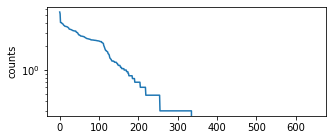

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
ax.set(yscale="log")
sns.lineplot(data=netlocs_count,y='counts',x=list(range(netlocs_count.shape[0])),ax=ax)
#after 280-something it's only 2 occurances and then only 1 for over half the cases, which we could aggregate as 'other'

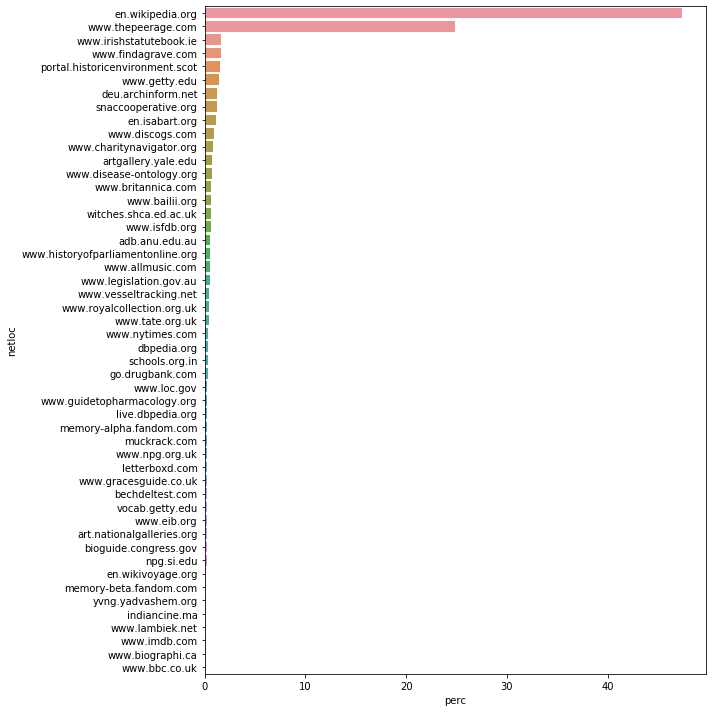

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(data=netlocs_count[:50], y='netloc', x='perc', ax=ax)
plt.tight_layout()
plt.show()

In [11]:
netlocs_count_rare = netlocs_count[netlocs_count['counts'] == 1]
netlocs_count_rare = netlocs_count_rare.netloc.tolist()

netlocs_count_other = netlocs_count[50:][~netlocs_count[50:].netloc.isin(netlocs_count_rare)]
netlocs_count_other = netlocs_count_other.netloc.tolist()

In [12]:
text_reference_df = all_url_df_eq1_f_good_netlocs.copy()
text_reference_df.drop(
    ['scheme','path','params','query','fragment','netloc_last','netloc_first','path_ext'],
    axis=1,
    inplace=True
)
text_reference_df['netloc_agg'] = text_reference_df['netloc']
text_reference_df.loc[text_reference_df.netloc.isin(netlocs_count_rare),'netloc_agg'] = 'RARE'
text_reference_df.loc[text_reference_df.netloc.isin(netlocs_count_other),'netloc_agg'] = 'OTHER'

text_reference_df

,reference_id,reference_property_id,reference_datatype,url,netloc,netloc_agg
0,00000e21b32ca823e31e7f9ff31f797796a8b4c7,P4656,url,https://en.wikipedia.org/w/index.php?title=New...,en.wikipedia.org,en.wikipedia.org
1,00007e5783e06a5cc266f339fc2ec576eb19df57,P854,url,https://www.bailii.org/uk/legis/num_reg/2010/u...,www.bailii.org,www.bailii.org
2,00008140ec95d0f33e37cd20f1363310de66bcc6,P4638,external-id,https://www.thepeerage.com/p4703.htm#i47021,www.thepeerage.com,www.thepeerage.com
3,0000a13d42d91ef52475b1c1cb822954157d0981,P4638,external-id,https://www.thepeerage.com/p5741.htm#i57410,www.thepeerage.com,www.thepeerage.com
4,0000b64d915b0cf142a303c69ec08e440c1bb81d,P4638,external-id,https://www.thepeerage.com/p10778.htm#i107780,www.thepeerage.com,www.thepeerage.com
...,...,...,...,...,...,...
679678,ffffd35e506ae3b45ba9fad8160dcfd14fc1f304,P4656,url,https://en.wikipedia.org/w/index.php?title=The...,en.wikipedia.org,en.wikipedia.org
679679,ffffd67be2a2a2e0e9ecffe73e6661c612c0901b,P4656,url,https://en.wikipedia.org/w/index.php?title=Joh...,en.wikipedia.org,en.wikipedia.org
679680,ffffdeea1fa66ed2e372b69e785864b3424bf238,P4656,url,https://en.wikipedia.org/w/index.php?title=HMS...,en.wikipedia.org,en.wikipedia.org
679681,fffff6ef03f2c8247944a7e882a38af2744e29f3,P699,external-id,http://www.disease-ontology.org/?id=DOID:0060295,www.disease-ontology.org,www.disease-ontology.org


First lets decide the sample size by balancing both CL/CI and crowdsourcing costs

As far as costs go, we would have X references in the sample. We will take 45 as golden data. The remaining (X-45) will be assembled in groups (tasksets) of 4 (with 2 additional GD, making up for 6 total in each taskset).
So we have (X-45)/4 tasksets. Each will be annotated 5 times **per task**, making for 5\*(X-45)/4 assignments. Each assignment, if paid \\$1, costs \\$1.20 (MTurk fee). So the final quote is: `Y=1.2*P*T*5*(X-45)/4`.

If we establish X = 660 (**CL=0.99, CI=0.05**), P = 1 (1 dollar payment), and T = 1 (1 task) the cost then is 922.5 dollars.

In [13]:
x = sample_size(text_reference_df.shape[0], confidence_level=99, confidence_interval=5)
y = 1.2*1*1*5*(x-45)/4
print('Sample size:',x,'; Price:',y)

Sample size: 660 ; Price: 922.5


Dividing these 676 (rounding up to get an even number) for the 52 netloc groups, we will sample 13 from each and keep track of the sampling weight.

Here, we will perform a simple **non-JS** check on each and assure code is either 2XX (good) or 3XX (redirected) and that language is *EN*. We will keep track of some websites that are exceptions of this, where the lack of JavaScript compromises language, for instance (like muckrack.com). We will extract the full JS-rendered website later, at a different machine (because this one at Cleopatra cannot run browser with head, and that will be needed).

In [14]:
from bs4 import BeautifulSoup
import requests
from urllib import parse
from langdetect import detect
from requests.exceptions import ReadTimeout, TooManyRedirects, ConnectionError, ConnectTimeout,\
    InvalidSchema, InvalidURL
from langdetect.lang_detect_exception import LangDetectException
from urllib3.exceptions import ProtocolError
import urllib.request
import socket
from requests.packages.urllib3.exceptions import InsecureRequestWarning
#requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
import re

import fasttext
ft_model = fasttext.load_model('lid.176.ftz')
def predict_language(text, k=20):
    ls, scores = ft_model.predict(text, k=k)  # top 20 matching languages
    ls = [l.replace('__label__','') for l in ls]
    return list(zip(ls,scores))

_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def get_url_language(html):
    try:
        soup = BeautifulSoup(html, "lxml")
        [s.decompose() for s in soup("script")]  # remove <script> elements
        if soup.body == None:
            return ('no body', None)
        body_text = _RE_COMBINE_WHITESPACE.sub(" ", soup.body.get_text(' ')).strip()
        return predict_language(body_text, k=1)[0]
    except Exception:
        raise    

def get_access_attrs(r, timeout=(10,60*2), as_dict=True, return_content=False):
    
    if r is None or r == 'None':
        res = {
            'url':r,
            'error_msg':None,
            'code':None,
            'content-type':None,
            'final_url':None,
            'reason':None,
            'language_crawl':None,
            'language_crawl_score':None
        }
        return res
    
    chunked_error_retries = 5
    
    with requests.Session() as session:        
        try:
            while True:
                headers = {
                    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) '+\
                        'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'
                }
                session.headers.update({"Accept-Language": "en-US"})
                resp = session.get(url=r, timeout=timeout, stream=True, verify=True, headers=headers)
                error_msg = 'none'
                if resp.status_code == 429:
                    time.sleep(int(resp.headers['Retry-After']))
                else:
                    break
                    
        except (TooManyRedirects) as e:
            resp = e.response
            error_msg = str(e)
        except (ReadTimeout, ConnectTimeout) as e:
            resp = requests.models.Response()
            resp.reason = 'timeout'
            resp.status_code = 408
            error_msg = str(e)
        except (ConnectionError) as e:
            resp = requests.models.Response()
            resp.reason = 'connection error'
            resp.status_code = 500
            error_msg = str(e)
        except (InvalidSchema, UnicodeError, InvalidURL) as e:
            resp = requests.models.Response()
            resp.reason = 'malformed or invalid url'
            resp.status_code = 400
            error_msg = str(e)
        except (Exception, KeyboardInterrupt) as e:
            #print(r,e)
            #traceback.print_exc()
            raise
            
        while True:
            try:
                attrs = {
                    'url': r,
                    'error_msg': error_msg,
                    'code': resp.status_code if hasattr(resp,'status_code') else None,
                    'content-type': resp.headers['Content-Type'] if hasattr(resp,'headers') and 'Content-Type' in resp.headers else None,
                    'final_url': resp.url if hasattr(resp,'url') else None,
                    'reason': resp.reason if hasattr(resp,'reason') else None,
                    'language_crawl': None,
                    'language_crawl_score': None
                }
                
                if return_content:
                    attrs['content'] = resp.content
                
                url_params = parse.parse_qs(parse.urlparse(r).query)
                for langkey in ['srlang','lang','language','srlanguage','p_lang']:
                    if langkey in url_params:
                        (attrs['language_crawl'], attrs['language_crawl_score']) = (url_params[langkey][0],1)
                    
                if attrs['language_crawl'] == None:
                    if attrs['content-type'] != None:
                        parseable_content_types = ['text/','application/xml','application/json']
                        if any([attrs['content-type'].startswith(p) for p in parseable_content_types]):
                            content = resp.content
                            if content is not None:
                                (attrs['language_crawl'], attrs['language_crawl_score']) = get_url_language(content)
                            else:
                                attrs['language_crawl'] = 'no content'
                        else:
                            attrs['language_crawl'] = 'not text/html'
                    else:
                        attrs['language_crawl'] = 'no content-type'
                if str(type(resp)) == "<class 'requests.models.Response'>" and hasattr(resp.raw,'close'):
                    resp.close()
                if as_dict:
                    return attrs
                else:
                    return ','.join([str(v) for v in attrs.values()])
                
            except requests.exceptions.ChunkedEncodingError as e:
                chunked_error_retries-=1
                if chunked_error_retries == 0:
                    attrs['language_crawl'] = 'parsing error'
                    return attrs
                #print('pipe problem, retrying')
                resp.close()
                resp = s.get(url=r, timeout=timeout, stream=True, verify=False, headers=headers)
                continue
            except requests.exceptions.ContentDecodingError as e:
                attrs['language_crawl'] = 'parsing error'
                return attrs
            except requests.exceptions.ConnectionError as e:
                attrs['language_crawl'] = 'connection error on reading'
                return attrs
            except Exception as e:
                print(r, e)
                #traceback.print_exc()
                raise

In [92]:
import pdb
ALLOW_LIST = ['muckrack.com']
BAD_DATATYPES = ['external-id','commonsMedia','url', 'globe-coordinate', 'wikibase-lexeme', 'wikibase-property']

def is_good_code(code):
    code_str = str(code)
    if code_str.startswith('2'):
        return True
    elif code_str.startswith('3'):
        return True
    return False

def reference_id_to_claim_ids(reference_id):
    try:
        cursor.execute(f'select claim_id from claims_refs where reference_id="{reference_id}";')
        sql_result = cursor.fetchall()
        return np.array(sql_result).reshape(-1)         
    except Exception:
        print(reference_id)
        print(sql_result)
        raise
        
def reference_id_to_claim_data(reference_id):
    claim_ids = reference_id_to_claim_ids(reference_id)
    reference_claim_data = []
    for claim_id in claim_ids:
        cursor.execute(f'select * from claims where claim_id="{claim_id}";')
        this_claim_data = cursor.fetchall()
        reference_claim_data = reference_claim_data + this_claim_data
    return reference_claim_data

def has_good_claims(reference_id):
    data = reference_id_to_claim_data(reference_id)
    for claim_data in data:
        if claim_data[4] not in BAD_DATATYPES:
            return True
    return False

def is_good_sample(row):
    if not is_good_code(row.code):
        return False
    if not row.language_crawl == 'en':
        if row.netloc not in ALLOW_LIST:
            return False
    if not row['content-type'].startswith('text/html'):
        return False
    if not has_good_claims(row.reference_id):
        return False
    return True

def draw_good_samples(original_df, SIZE): 
    df = original_df.copy()
    df_sample = df.sample(SIZE, random_state=SEED)
    df_sample[
        ['url_2', 'error_msg', 'code', 'content-type', 'final_url', 'reason', 'language_crawl','language_crawl_score']
    ] = pd.DataFrame(df_sample.url.progress_apply(get_access_attrs).tolist(), index=df_sample.index)
    
    i = 0
    
    df_sample_good_idx = df_sample.apply(is_good_sample, axis=1)
    #pdb.set_trace()
    while not df_sample_good_idx.all():
        
        print(f'{df_sample.loc[~df_sample_good_idx]} are bad')
        df_sample = df_sample.drop(
            df_sample.loc[~df_sample_good_idx].index, axis=0
        )
        #Also drop them from the sample pool
        df = df.drop(
            df_sample_good_idx.loc[~df_sample_good_idx].index, axis=0
        )
        print('------------------------')
        
        nb_to_resample = SIZE - df_sample.shape[0]
        i = i+1 
        df_sample_new = df.sample(nb_to_resample, random_state=SEED+i)
        df_sample_new[
            ['url_2', 'error_msg', 'code', 'content-type', 'final_url', 'reason', 'language_crawl','language_crawl_score']
        ] = pd.DataFrame(df_sample_new.url.progress_apply(get_access_attrs).tolist(), index=df_sample_new.index)
        
        df_sample = pd.concat([df_sample, df_sample_new])
        df_sample_good_idx = df_sample.apply(is_good_sample, axis=1)
        
    assert df_sample.code.apply(is_good_code).all()
    if df_sample.netloc.unique()[0] not in ALLOW_LIST:
        assert (df_sample.language_crawl == 'en').all()
    assert df_sample['content-type'].apply(lambda x : x.startswith('text/html')).all()
    
    return df_sample    

In [99]:
v = [v[1] for v in reference_id_to_claim_data('b1c32f3977b741d5634b3d5228ebf60b329f3444')]
for vv in v:
    print(claim_id_to_claim_url(vv))

https://www.wikidata.org/wiki/Q76385056#Q76385056$eeedd509-4450-a82f-fafa-09b2527cee99


In [93]:
netloc='www.loc.gov'
text_reference_df[text_reference_df.netloc_agg == netloc]
draw_good_samples(text_reference_df_netloc, SAMPLE_SIZE_PER_NETLOC)


                                    reference_id reference_property_id  \
395637  94acd3bf10190b922e2d9d1a3b4cc77b9c506bb8                 P1144   
581146  daa5e85b042786724b913f4d0b0c15eaa75249cf                 P1144   
659362  f844dcecc60efef0bb19b3d1c3ce9236200f2eb5                 P1144   
330752  7c40b7ce49ce5f9bbb74e5fc30230aaead1584d4                 P1144   
114817  2b25f61537b1dfa6899ab605f4efec0d01df13ff                 P1144   
165894  3e56be8b3bd60b57a4d9dd5064a8297de240e5ca                 P1144   
472610  b19535debe0d5fe73ae065971d9b8f392956f945                 P1144   
105390  279111e1ed406faba39320b987ade5536889f8ca                 P1144   
416751  9c9fdfb98fe88eff237f4c55a807deec056314cc                 P1144   
172399  40c47bc20473fc1c0f16a4263ab427967931651d                 P1144   
75374   1c3bf80cc1423d960e609fa70ded511725f9443d                 P1144   
548870  ce7f843e41c2f612798b5aed4d366c019e3a875f                 P1144   
227067  555936165228656cf94788a0a4bb4


                                    reference_id reference_property_id  \
666709  fb0f27efebf8ba07cec1d2122b87875d82218662                 P1144   
653266  f5eda81dff9bfebdbed4576c7f981deb305f1d56                 P1144   
649969  f4a8dcbf5fbdd2da4db493c2de2fc447266b4634                 P1144   
517448  c285045eef9fbe3e55775828ac41a8dcff7dee75                 P1144   
147946  3795e9a92aacea0478a6f2ee75eeb7852112b6f8                 P1144   
399710  962ca885f50f2813dacaf7b11a7cf51179f608b7                 P1144   
337181  7ead442c94de9e3fda3cfddac465e11de16a130d                 P1144   
252524  5ef339e96d2ac7b65466a2cbf646c41818642504                 P1144   
583231  db6e24146885339e076b7e639a797ee6f896d7de                 P1144   
622188  ea1e7d96f1624b9bc226ba270b23aaa1d4765ed3                 P1144   
437216  a44a0427f8687dd442926d173db67baa53c97d9e                 P1144   
295405  6ef63d493ffb26eca15683ec3e531ed7f95e393a                 P1144   
491877  b8eb95af4816ece72b95c8885bfad


                                    reference_id reference_property_id  \
596923  e08a9b061d89e20bc568e72c4f8bc2cc0b2e05f3                 P1144   
26288   09ce379fabb026330d75902acd6eeb3a88b4b780                 P1144   
386880  916e52f44f232f8e2c23871939d5246e6d88ee14                 P1144   
372085  8bc8dba65eadd33a218634c364f59d16b2ffe941                 P1144   
270103  65830ec4670549c5dcc706df94cd1c8f68112875                 P1144   
235295  587644681614dc3240cfaeb71803d0761ce37372                 P1144   
151670  3906529ad80fe5767afb48988815b1644841024b                 P1144   
584311  dbd3c264dbc53c2330c9ec4598f907b417fd5276                 P1144   
24979   09508214b4068e90bc188ef47283b330e0cbfe49                 P1144   
90770   2206a362cf7f91481778b869fbe32ac386b6204d                 P1144   
375096  8cf6227da1d2f2185e7d6a89c79e756c6d242889                 P1144   
363508  8887aabb14c20a679df05021966da3eb0897e0c9                 P1144   

       reference_datatype           


                                    reference_id reference_property_id  \
416887  9cac82d0d452524a0e532cb3187a90fc48dbb703                 P1144   
628605  ec913537b31724b6fc0d458f33978bf7e6e1d62e                 P1144   
226545  5523721fe5557acd7c978a5e9c89c5dbce56218e                 P1144   
4757    01c6363b7f56dabec4eb198495458efd899b987c                 P1144   
47667   11dbf6d1525af0f150d80b98fbe1ea73df0d3640                 P1144   
156186  3ab0bae81572af82b3824ae08fc952febc0997da                  P854   
223806  5418e551de29576b442f50885664423245110a35                 P1144   
635565  ef2c99e5baf4d43e3172ef2c85cb1cf062faf2d3                 P1144   
50130   12d16817609618cd10ec74c5943f4087e12043ce                 P1144   

       reference_datatype                                        url  \
416887        external-id         https://www.loc.gov/item/10031153/   
628605        external-id         https://www.loc.gov/item/18011115/   
226545        external-id         https://


                                    reference_id reference_property_id  \
249026  5d98371cc1eb9868680d9419cb0702ce9afcf05a                 P1144   
659694  f8665ddd99af737b91e509462c27fa1f268d6dfd                 P1144   
51124   132edfd600d4e64b8c33531803dfb9852f928cc2                 P1144   
371503  8b924fe6a4aaff05f8219a09ba04f629d9b1d32c                 P1144   
274717  673819c933f7569081da17a0454d5ec244960757                 P1144   
228286  55d29a039e2fa212bd52b3bb2257fffb4f7e24d9                 P1144   
119034  2cb687003c04c4deb5d8fdc457256768e87c565b                 P1144   
451186  a984747ec4cf708e69abb195295bac2eec94662e                 P1144   

       reference_datatype                                   url       netloc  \
249026        external-id  https://www.loc.gov/item/sf85004110/  www.loc.gov   
659694        external-id    https://www.loc.gov/item/07012309/  www.loc.gov   
51124         external-id    https://www.loc.gov/item/12022752/  www.loc.gov   
371503      


                                    reference_id reference_property_id  \
32663   0c2dc10377be460d0094350f836336b77bfd5535                 P1144   
654805  f6824e879673d5769d7884b5406bd1a3140969b4                  P854   
159687  3c01592df21544a67916df8f300e591de87cc60e                 P1144   
626581  ebca575140e628756964149599f1dea7c29bc35a                 P1144   
104170  2719820d7602985e5be830c213d3d227c107d959                 P1144   
609682  e5637e88259e6fbbccdeb1fd0c8ca58ed91bf3cd                 P1144   
295390  6ef4d588b9f7006715fa13e4917b51fdb9fbde8e                 P1144   
301825  7160b8506128925fe48691680692044cfd08d5dc                 P1144   

       reference_datatype                                                url  \
32663         external-id                 https://www.loc.gov/item/11014765/   
654805                url  https://www.loc.gov/marc/organizations/org-sea...   
159687        external-id                 https://www.loc.gov/item/12029102/   
626581      


                                    reference_id reference_property_id  \
323058  7957c81d16140d85f67d7b5a1da3b7f3a3b656e9                 P1144   
88908   215501f61ea46ba528aa90d071ed06d5300a3f4d                 P1144   
412743  9b22cfecd8aa1e86555bbc8f093b12cf1b049f10                 P1144   
297121  6f9c00d573b7b3f507ba2e6b36e9ff3d32c6e977                 P1144   
637116  efc3deae16ded7271baa16ab92002a02a21da08d                 P1144   
49654   12a0ef2f037b68cacf411e881622ad47c1217a39                 P1144   

       reference_datatype                                    url       netloc  \
323058        external-id     https://www.loc.gov/item/32024449/  www.loc.gov   
88908         external-id     https://www.loc.gov/item/12018435/  www.loc.gov   
412743        external-id     https://www.loc.gov/item/12033576/  www.loc.gov   
297121        external-id  https://www.loc.gov/item/unk82070250/  www.loc.gov   
637116        external-id     https://www.loc.gov/item/07022845/  www.loc.g


                                    reference_id reference_property_id  \
446213  a7adcc573aa24108f30ca491709b8d2390dcc7e7                 P1144   
659369  f84568cb3ed82b8c7033f6984fdb6fd473782841                 P1144   
636287  ef71d8310478d156be34faf66a08303ef5c23a48                 P1144   
222399  53909edd977508e8d92cda326f9d1d68318dc13e                 P1144   

       reference_datatype                                   url       netloc  \
446213        external-id    https://www.loc.gov/item/17013357/  www.loc.gov   
659369        external-id    https://www.loc.gov/item/15017609/  www.loc.gov   
636287        external-id  https://www.loc.gov/item/gs11000599/  www.loc.gov   
222399        external-id    https://www.loc.gov/item/10033163/  www.loc.gov   

         netloc_agg                                 url_2 error_msg  code  \
446213  www.loc.gov    https://www.loc.gov/item/17013357/      none   200   
659369  www.loc.gov    https://www.loc.gov/item/15017609/      none   200


                                    reference_id reference_property_id  \
320085  783772bda2aa746f72c078932b1c40fb33624ad3                 P1144   
294455  6e986f9d38219d54a34a4591fb2f513ae3dfeb15                 P1144   

       reference_datatype                                 url       netloc  \
320085        external-id  https://www.loc.gov/item/19002993/  www.loc.gov   
294455        external-id  https://www.loc.gov/item/12023461/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
320085  www.loc.gov  https://www.loc.gov/item/19002993/      none   200   
294455  www.loc.gov  https://www.loc.gov/item/12023461/      none   200   

                    content-type                           final_url reason  \
320085  text/html; charset=UTF-8  https://www.loc.gov/item/19002993/     OK   
294455  text/html; charset=UTF-8  https://www.loc.gov/item/12023461/     OK   

       language_crawl  language_crawl_score  
320085             en          


                                    reference_id reference_property_id  \
353043  849527bbc455da875a64eb8cdbd5970a440058d5                 P1144   

       reference_datatype                                 url       netloc  \
353043        external-id  https://www.loc.gov/item/15008187/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
353043  www.loc.gov  https://www.loc.gov/item/15008187/      none   200   

                    content-type                           final_url reason  \
353043  text/html; charset=UTF-8  https://www.loc.gov/item/15008187/     OK   

       language_crawl  language_crawl_score  
353043             en              0.304478   are bad
------------------------



                                    reference_id reference_property_id  \
580378  da609012679a856803fd38844e3155b0a3e35f47                 P1144   

       reference_datatype                                 url       netloc  \
580378        external-id  https://www.loc.gov/item/22006634/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
580378  www.loc.gov  https://www.loc.gov/item/22006634/      none   200   

                    content-type                           final_url reason  \
580378  text/html; charset=UTF-8  https://www.loc.gov/item/22006634/     OK   

       language_crawl  language_crawl_score  
580378             en              0.283186   are bad
------------------------



                                    reference_id reference_property_id  \
423928  9f4eb3701411d522e21f408f93f94d002bcb0372                 P1144   

       reference_datatype                                 url       netloc  \
423928        external-id  https://www.loc.gov/item/05024427/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
423928  www.loc.gov  https://www.loc.gov/item/05024427/      none   200   

                    content-type                           final_url reason  \
423928  text/html; charset=UTF-8  https://www.loc.gov/item/05024427/     OK   

       language_crawl  language_crawl_score  
423928             en              0.283476   are bad
------------------------



                                    reference_id reference_property_id  \
225280  54a7f0217584424a8963b8e7364be1ea6ae27927                 P1144   

       reference_datatype                                 url       netloc  \
225280        external-id  https://www.loc.gov/item/33004837/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
225280  www.loc.gov  https://www.loc.gov/item/33004837/      none   200   

                    content-type                           final_url reason  \
225280  text/html; charset=UTF-8  https://www.loc.gov/item/33004837/     OK   

       language_crawl  language_crawl_score  
225280             en              0.297736   are bad
------------------------



                                    reference_id reference_property_id  \
129738  30bb71ab708a0fde5cf877c070b0fd4462529408                 P1144   

       reference_datatype                                 url       netloc  \
129738        external-id  https://www.loc.gov/item/18023270/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
129738  www.loc.gov  https://www.loc.gov/item/18023270/      none   200   

                    content-type                           final_url reason  \
129738  text/html; charset=UTF-8  https://www.loc.gov/item/18023270/     OK   

       language_crawl  language_crawl_score  
129738             en              0.297553   are bad
------------------------



                                    reference_id reference_property_id  \
239662  5a0c27ba4702ffcec97de7e5e69bf53a814e6133                 P1144   

       reference_datatype                                 url       netloc  \
239662        external-id  https://www.loc.gov/item/12028738/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
239662  www.loc.gov  https://www.loc.gov/item/12028738/      none   200   

                    content-type                           final_url reason  \
239662  text/html; charset=UTF-8  https://www.loc.gov/item/12028738/     OK   

       language_crawl  language_crawl_score  
239662             en              0.294237   are bad
------------------------



                                    reference_id reference_property_id  \
361866  87ec690b9e347364c95f9175c0b6cc6008e595bd                 P1144   

       reference_datatype                                   url       netloc  \
361866        external-id  https://www.loc.gov/item/ca17001578/  www.loc.gov   

         netloc_agg                                 url_2 error_msg  code  \
361866  www.loc.gov  https://www.loc.gov/item/ca17001578/      none   200   

                    content-type                             final_url reason  \
361866  text/html; charset=UTF-8  https://www.loc.gov/item/ca17001578/     OK   

       language_crawl  language_crawl_score  
361866             en              0.286272   are bad
------------------------



                                    reference_id reference_property_id  \
102420  266eb4becacbf6dd88b565a24eab22aa75d3f4bd                 P1144   

       reference_datatype                                 url       netloc  \
102420        external-id  https://www.loc.gov/item/07019796/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
102420  www.loc.gov  https://www.loc.gov/item/07019796/      none   200   

                    content-type                           final_url reason  \
102420  text/html; charset=UTF-8  https://www.loc.gov/item/07019796/     OK   

       language_crawl  language_crawl_score  
102420             en              0.286002   are bad
------------------------



                                   reference_id reference_property_id  \
81480  1e83fe7b0b9f1a55bd4559e4efdcd31409030efc                 P1144   

      reference_datatype                                 url       netloc  \
81480        external-id  https://www.loc.gov/item/03007344/  www.loc.gov   

        netloc_agg                               url_2 error_msg  code  \
81480  www.loc.gov  https://www.loc.gov/item/03007344/      none   200   

                   content-type                           final_url reason  \
81480  text/html; charset=UTF-8  https://www.loc.gov/item/03007344/     OK   

      language_crawl  language_crawl_score  
81480             en              0.301836   are bad
------------------------



                                    reference_id reference_property_id  \
425234  9fcaaac4b93878a8ebb87a286a7fb18410f3413e                 P1144   

       reference_datatype                                 url       netloc  \
425234        external-id  https://www.loc.gov/item/11001288/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
425234  www.loc.gov  https://www.loc.gov/item/11001288/      none   200   

                    content-type                           final_url reason  \
425234  text/html; charset=UTF-8  https://www.loc.gov/item/11001288/     OK   

       language_crawl  language_crawl_score  
425234             en              0.297022   are bad
------------------------



                                    reference_id reference_property_id  \
427764  a0bf1553597ab79c5cfa87b8572e7d82dc5e3308                 P1144   

       reference_datatype                                 url       netloc  \
427764        external-id  https://www.loc.gov/item/07035430/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
427764  www.loc.gov  https://www.loc.gov/item/07035430/      none   200   

                    content-type                           final_url reason  \
427764  text/html; charset=UTF-8  https://www.loc.gov/item/07035430/     OK   

       language_crawl  language_crawl_score  
427764             en              0.338648   are bad
------------------------



                                    reference_id reference_property_id  \
408933  99b334dd6c7f5f618cd943db392c757175580164                 P1144   

       reference_datatype                                 url       netloc  \
408933        external-id  https://www.loc.gov/item/01014018/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
408933  www.loc.gov  https://www.loc.gov/item/01014018/      none   200   

                    content-type                           final_url reason  \
408933  text/html; charset=UTF-8  https://www.loc.gov/item/01014018/     OK   

       language_crawl  language_crawl_score  
408933             en               0.31272   are bad
------------------------



                                    reference_id reference_property_id  \
586514  dca5f717b5efc17b2f085375bd1ec5ddd7b2cd83                 P1144   

       reference_datatype                                   url       netloc  \
586514        external-id  https://www.loc.gov/item/sn85005194/  www.loc.gov   

         netloc_agg                                 url_2 error_msg  code  \
586514  www.loc.gov  https://www.loc.gov/item/sn85005194/      none   404   

                    content-type                             final_url  \
586514  text/html; charset=UTF-8  https://www.loc.gov/item/sn85005194/   

           reason language_crawl  language_crawl_score  
586514  Not Found             en               0.22534   are bad
------------------------



                                    reference_id reference_property_id  \
444107  a6df48613d0031cd64de3a6a38149c17288baca2                 P1144   

       reference_datatype                                 url       netloc  \
444107        external-id  https://www.loc.gov/item/08034902/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
444107  www.loc.gov  https://www.loc.gov/item/08034902/      none   200   

                    content-type                           final_url reason  \
444107  text/html; charset=UTF-8  https://www.loc.gov/item/08034902/     OK   

       language_crawl  language_crawl_score  
444107             en              0.251568   are bad
------------------------



                                   reference_id reference_property_id  \
56549  153931eb914a0a3fdcdc7270e9495e56f81f2d28                 P1144   

      reference_datatype                                    url       netloc  \
56549        external-id  https://www.loc.gov/item/agr09000211/  www.loc.gov   

        netloc_agg                                  url_2 error_msg  code  \
56549  www.loc.gov  https://www.loc.gov/item/agr09000211/      none   200   

                   content-type                              final_url reason  \
56549  text/html; charset=UTF-8  https://www.loc.gov/item/agr09000211/     OK   

      language_crawl  language_crawl_score  
56549             en               0.29455   are bad
------------------------



                                   reference_id reference_property_id  \
30076  0b31f4baef5853aec1d5980b18059376426f353a                 P1144   

      reference_datatype                                 url       netloc  \
30076        external-id  https://www.loc.gov/item/02028253/  www.loc.gov   

        netloc_agg                               url_2 error_msg  code  \
30076  www.loc.gov  https://www.loc.gov/item/02028253/      none   200   

                   content-type                           final_url reason  \
30076  text/html; charset=UTF-8  https://www.loc.gov/item/02028253/     OK   

      language_crawl  language_crawl_score  
30076             en              0.319583   are bad
------------------------



                                    reference_id reference_property_id  \
492389  b91f305f1305b07def762c5f907f6b9e6d87693f                 P1144   

       reference_datatype                                 url       netloc  \
492389        external-id  https://www.loc.gov/item/22012987/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
492389  www.loc.gov  https://www.loc.gov/item/22012987/      none   200   

                    content-type                           final_url reason  \
492389  text/html; charset=UTF-8  https://www.loc.gov/item/22012987/     OK   

       language_crawl  language_crawl_score  
492389             en              0.319347   are bad
------------------------



                                   reference_id reference_property_id  \
61912  17341531794fe979a7c93739d16cdaa850d04532                 P1144   

      reference_datatype                                 url       netloc  \
61912        external-id  https://www.loc.gov/item/04004018/  www.loc.gov   

        netloc_agg                               url_2 error_msg  code  \
61912  www.loc.gov  https://www.loc.gov/item/04004018/      none   200   

                   content-type                           final_url reason  \
61912  text/html; charset=UTF-8  https://www.loc.gov/item/04004018/     OK   

      language_crawl  language_crawl_score  
61912             en              0.279765   are bad
------------------------



                                    reference_id reference_property_id  \
416088  9c5ab02482544c91455fb1c186b0013b690f6d6d                 P1144   

       reference_datatype                                 url       netloc  \
416088        external-id  https://www.loc.gov/item/03002766/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
416088  www.loc.gov  https://www.loc.gov/item/03002766/      none   200   

                    content-type                           final_url reason  \
416088  text/html; charset=UTF-8  https://www.loc.gov/item/03002766/     OK   

       language_crawl  language_crawl_score  
416088             en              0.302773   are bad
------------------------



                                    reference_id reference_property_id  \
296869  6f83420e42cc20361d345e00fdb3a0f4e25bdcb3                 P1144   

       reference_datatype                                 url       netloc  \
296869        external-id  https://www.loc.gov/item/12012250/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
296869  www.loc.gov  https://www.loc.gov/item/12012250/      none   200   

                    content-type                           final_url reason  \
296869  text/html; charset=UTF-8  https://www.loc.gov/item/12012250/     OK   

       language_crawl  language_crawl_score  
296869             en              0.317002   are bad
------------------------



                                    reference_id reference_property_id  \
270176  658aa10f56d7f6a9d4355d6b5e524cec7d27efd6                 P1144   

       reference_datatype                                 url       netloc  \
270176        external-id  https://www.loc.gov/item/11029383/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
270176  www.loc.gov  https://www.loc.gov/item/11029383/      none   200   

                    content-type                           final_url reason  \
270176  text/html; charset=UTF-8  https://www.loc.gov/item/11029383/     OK   

       language_crawl  language_crawl_score  
270176             en              0.338559   are bad
------------------------



                                    reference_id reference_property_id  \
307195  7357d3526e8e560e1234a9457f6b6ba322bd17e9                 P1144   

       reference_datatype                                 url       netloc  \
307195        external-id  https://www.loc.gov/item/21021879/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
307195  www.loc.gov  https://www.loc.gov/item/21021879/      none   200   

                    content-type                           final_url reason  \
307195  text/html; charset=UTF-8  https://www.loc.gov/item/21021879/     OK   

       language_crawl  language_crawl_score  
307195             en              0.314226   are bad
------------------------



                                    reference_id reference_property_id  \
265572  63d5136463081b7030333c30accd92761cd822c8                 P1144   

       reference_datatype                                 url       netloc  \
265572        external-id  https://www.loc.gov/item/04012888/  www.loc.gov   

         netloc_agg                               url_2 error_msg  code  \
265572  www.loc.gov  https://www.loc.gov/item/04012888/      none   200   

                    content-type                           final_url reason  \
265572  text/html; charset=UTF-8  https://www.loc.gov/item/04012888/     OK   

       language_crawl  language_crawl_score  
265572             en              0.300099   are bad
------------------------


,reference_id,reference_property_id,reference_datatype,url,netloc,netloc_agg,url_2,error_msg,code,content-type,final_url,reason,language_crawl,language_crawl_score
393364,93d56ddd9243517b97751e365a8ecc361c6dfb24,P854,url,https://www.loc.gov/item/n80020417/james-h-bil...,www.loc.gov,www.loc.gov,https://www.loc.gov/item/n80020417/james-h-bil...,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/n80020417/james-h-bil...,OK,en,0.688332
178198,42f9085c5323f43836ac6b2e2ec8fbd4411ce5fc,P1144,external-id,https://www.loc.gov/item/15023407/,www.loc.gov,www.loc.gov,https://www.loc.gov/item/15023407/,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/15023407/,OK,en,0.305824
344719,817810e31e3596089a0f152e6b96a60975670a97,P854,url,https://www.loc.gov/item/99483604/,www.loc.gov,www.loc.gov,https://www.loc.gov/item/99483604/,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/99483604/,OK,en,0.401701
643605,f2368c3cdf237f692279fe9d8b0ac0b517da7a45,P854,url,https://www.loc.gov/resource/pga.05311/,www.loc.gov,www.loc.gov,https://www.loc.gov/resource/pga.05311/,none,200,text/html; charset=UTF-8,https://www.loc.gov/resource/pga.05311/,OK,en,0.404245
582244,db0ea0b1d3343a385fa94cfea741d4a657a4c2bc,P8655,external-id,https://www.loc.gov/item/va1658,www.loc.gov,www.loc.gov,https://www.loc.gov/item/va1658,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/va1658,OK,en,0.526745
473090,b1c32f3977b741d5634b3d5228ebf60b329f3444,P854,url,https://www.loc.gov/rr/amed/div.html,www.loc.gov,www.loc.gov,https://www.loc.gov/rr/amed/div.html,none,200,text/html,https://www.loc.gov/rr/amed/div.html,OK,en,0.953144
206651,4da7e17ef82a5b2d7503be6ed1d3bd14f503f534,P854,url,https://www.loc.gov/about/awards-and-honors/li...,www.loc.gov,www.loc.gov,https://www.loc.gov/about/awards-and-honors/li...,none,200,text/html; charset=UTF-8,https://www.loc.gov/about/awards-and-honors/li...,OK,en,0.365215
178198,42f9085c5323f43836ac6b2e2ec8fbd4411ce5fc,P1144,external-id,https://www.loc.gov/item/15023407/,www.loc.gov,www.loc.gov,https://www.loc.gov/item/15023407/,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/15023407/,OK,en,0.305824
349864,835e52d9123604e0c383ce669ba144f601190672,P854,url,https://www.loc.gov/pictures/item/2011645164/,www.loc.gov,www.loc.gov,https://www.loc.gov/pictures/item/2011645164/,none,200,text/html; charset=UTF-8,https://www.loc.gov/pictures/item/2011645164/,OK,en,0.877744
125064,2ef66f25392580437d799dc8108a1c50fb89dafe,P1144,external-id,https://www.loc.gov/item/2019681383/,www.loc.gov,www.loc.gov,https://www.loc.gov/item/2019681383/,none,200,text/html; charset=UTF-8,https://www.loc.gov/item/2019681383/,OK,en,0.491569


In [100]:
sampled_dfs = []
netlocs = text_reference_df.netloc_agg[~text_reference_df.netloc_agg.isna()].unique()
SAMPLE_SIZE = sample_size(text_reference_df.shape[0], confidence_level=99, confidence_interval=5)
SAMPLE_SIZE_PER_NETLOC = int(np.ceil(SAMPLE_SIZE/netlocs.shape[0]))

for i, netloc in enumerate(netlocs):
    print(i, netloc)
    if netloc in netlocs[:0]:
        continue
    text_reference_df_netloc = text_reference_df[text_reference_df.netloc_agg == netloc]
    
    #text_reference_df_netloc_sample = text_reference_df_netloc.sample(SAMPLE_SIZE_PER_NETLOC, random_state=SEED)
    
    text_reference_df_netloc_sample = draw_good_samples(text_reference_df_netloc, SAMPLE_SIZE_PER_NETLOC)
    
    text_reference_df_netloc_sample['sampling_weight_vb'] = '|'.join([
            str(text_reference_df_netloc.shape[0]),
            str(SAMPLE_SIZE_PER_NETLOC)
        ])
    text_reference_df_netloc_sample['sampling_weight'] = text_reference_df_netloc.shape[0]/SAMPLE_SIZE_PER_NETLOC
    sampled_dfs.append(text_reference_df_netloc_sample)
    #break
    clear_output(wait=True)
    
text_reference_sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)
text_reference_sampled_df

,reference_id,reference_property_id,reference_datatype,url,netloc,netloc_agg,url_2,error_msg,code,content-type,final_url,reason,language_crawl,language_crawl_score,sampling_weight_vb,sampling_weight
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,P4656,url,https://en.wikipedia.org/w/index.php?title=G._...,en.wikipedia.org,en.wikipedia.org,https://en.wikipedia.org/w/index.php?title=G._...,none,200,text/html; charset=UTF-8,https://en.wikipedia.org/w/index.php?title=G._...,OK,en,0.934613,321744|13,24749.538462
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,P4656,url,https://en.wikipedia.org/w/index.php?title=Seb...,en.wikipedia.org,en.wikipedia.org,https://en.wikipedia.org/w/index.php?title=Seb...,none,200,text/html; charset=UTF-8,https://en.wikipedia.org/w/index.php?title=Seb...,OK,en,0.646651,321744|13,24749.538462
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,P4656,url,https://en.wikipedia.org/w/index.php?title=Ave...,en.wikipedia.org,en.wikipedia.org,https://en.wikipedia.org/w/index.php?title=Ave...,none,200,text/html; charset=UTF-8,https://en.wikipedia.org/w/index.php?title=Ave...,OK,en,0.842498,321744|13,24749.538462
3,76b04346ad57869d9e5ae1007ba8343d708ab6f9,P4656,url,https://en.wikipedia.org/w/index.php?title=Yut...,en.wikipedia.org,en.wikipedia.org,https://en.wikipedia.org/w/index.php?title=Yut...,none,200,text/html; charset=UTF-8,https://en.wikipedia.org/w/index.php?title=Yut...,OK,en,0.608352,321744|13,24749.538462
4,1ee71b39caf6df395c64b436fea4895692812d38,P4656,url,https://en.wikipedia.org/w/index.php?title=Dol...,en.wikipedia.org,en.wikipedia.org,https://en.wikipedia.org/w/index.php?title=Dol...,none,200,text/html; charset=UTF-8,https://en.wikipedia.org/w/index.php?title=Dol...,OK,en,0.856581,321744|13,24749.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,30bba624155e8c3a681add4b08967cfb23821a4b,P854,url,https://indiancine.ma/CCE,indiancine.ma,indiancine.ma,https://indiancine.ma/CCE,none,200,text/html; charset=utf-8,https://indiancine.ma/CCE,OK,en,0.612925,993|13,76.384615
672,fcfe8a0995f157f013786f42fb33dd928c3ebb9c,P854,url,https://indiancine.ma/ARC,indiancine.ma,indiancine.ma,https://indiancine.ma/ARC,none,200,text/html; charset=utf-8,https://indiancine.ma/ARC,OK,en,0.753929,993|13,76.384615
673,b39988975bcaf5f41ff4143e7624873d5dafba0d,P854,url,https://indiancine.ma/BQK,indiancine.ma,indiancine.ma,https://indiancine.ma/BQK,none,200,text/html; charset=utf-8,https://indiancine.ma/BQK,OK,en,0.576731,993|13,76.384615
674,eca1aeeae63d107ee1bc18b85fce09b1d51c3323,P854,url,https://indiancine.ma/BUR,indiancine.ma,indiancine.ma,https://indiancine.ma/BUR,none,200,text/html; charset=utf-8,https://indiancine.ma/BUR,OK,en,0.666638,993|13,76.384615


In [66]:
assert (text_reference_sampled_df.url == text_reference_sampled_df.url_2).all()
text_reference_sampled_df = text_reference_sampled_df.drop('url_2', axis=1)

In [67]:
text_reference_sampled_df.to_csv('text_reference_sampled_df.csv', index=None)